In [1]:
# install packages used in this script

import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import momepy
import networkx as nx
import shapely
import numpy as np

import warnings
warnings.filterwarnings("ignore")

ModuleNotFoundError: No module named 'geopandas'

In [63]:
low_stress_path = '../../data/lowstress_SB/lowstress_SB.shp'
low_stress = gpd.read_file(low_stress_path)

all_streets_path = '../../data/all_street_pfb_SB/neighborhood_ways.shp'
all_streets = gpd.read_file(all_streets_path)

block_path = '../../data/20231120_blockgroup/var1120.shp'
blocks = gpd.read_file(block_path)
blocks = blocks.to_crs(all_streets.crs)

In [178]:
# remove multilinestrings from the low_stress dataframe. These are small roads that have been breaks between them, 
# but aren't located on primary roads
def remove_multis(shp_file):
    geoms = shp_file['geometry']
    geomTypes = pd.Series([type(line) for line in geoms])
    multiTypes = geoms.apply(lambda x: isinstance(x, shapely.geometry.multilinestring.MultiLineString))
    print("multitype polylines being removed: ", len(multiTypes))
    print("multitype polylines being removed: ", len(multiTypes))
    return shp_file[~multiTypes]

# Calculating connectivity indicators
# network density = (total length of bike links)/(block area)
def calc_net_density(bike_edges, polygon):
    total_len = sum(bike_edges['edge_length'])/1000 # covert to km
    total_area = polygon['area'].values[0]/1000000 #convert to km2
    net_density = total_len/total_area # need to figure out what my data layers are
    return net_density

# Gamma Connectivity (degree of connectivity) = edges/lmax, where lmax = 3(n-2)
def calc_gamma(nodes, edges):
    gamma_connectivity = (sum(edges['weights']))/(3*(len(nodes)-2))
    return gamma_connectivity

# Degree of network coverage (Number of bike links)/(number of street links)
def calc_net_coverage(bike_edges, street_edges):
    net_coverage = sum(bike_edges['weights'])/sum(street_edges['weights'])
    return net_coverage

# Intersection density (Number of bike network intersections)/(block area)
def calc_int_density(bike_nodes, polygon):
    total_area = polygon['area'].values[0]/1000000 #convert to km2
    int_density = len(bike_nodes)/total_area
    return int_density

# Degree of network complexity (Number of bike links)/(bike nodes)
def calc_complexity(bike_edges, bike_nodes):
    net_complexity = sum(bike_edges['weights'])/(len(bike_nodes))
    return net_complexity

In [179]:
# export multilines that were removed and export edges + nodes that were created
# filter out crosswalks on low stress and high stress

# do a comparison of geopackage with comfort levels 1-3 vs all streets
# TWO WAYS OF DEFINING BIKE NETWORKS
# 1: stress level (low stress)
# 2: bike infrastructure (a lot simpler)

#combine bike gamma 


# merge multilines

# all units in meters (from crs)

# output census block shapefile path with appended connectivity indicator data
output_blocks_path = './outputs/connectivity_blocks.shp'

# list to store connectivity indicators for each block
connectivity_indicators_list = {
        'GEOID': [],
        'b_net_density': [],
        'b_gamma': [],
        's_gamma': [],
        'b_coverage': [],
        'b_int_density': [],
        'b_complexity': []
    }

# iterate through each census block, calculating and storing connectivity indicators
for index, row in blocks.iterrows():
        
    row = row.to_frame().T # reshape row to be a dataframe with columns
    id = row['GEOID'].values[0] # store unique GEOID of the current census block
    polygon = gpd.GeoDataFrame(row, geometry='geometry', crs=blocks.crs)
    bike_polylines = remove_multis(low_stress)
    all_streets_polylines = remove_multis(all_streets)

    # select networks that reside in current block
    clipped_bike = gpd.sjoin(bike_polylines, polygon, how='inner', op='intersects')
    clipped_streets = gpd.sjoin(all_streets_polylines, polygon, how='inner', op='intersects')

    # find the new edge lengths of roads that are cut by block boundaries
    clipped_bike_edge = bike_polylines.clip(polygon)
    clipped_bike['edge_length'] = clipped_bike_edge['geometry'].length
    clipped_streets_edge = all_streets_polylines.clip(polygon)
    clipped_streets['edge_length'] = clipped_streets_edge['geometry'].length

    # calculate a weighting factor for clipped edges
    clipped_bike['weights'] = clipped_bike['edge_length']/clipped_bike['geometry'].length
    clipped_streets['weights'] = clipped_streets['edge_length']/clipped_streets['geometry'].length

    # Create a graph of nodes and edges where roads intersect
    bike_G = momepy.gdf_to_nx(clipped_bike, approach="primal")
    street_G = momepy.gdf_to_nx(clipped_streets, approach="primal")
    
    # Getting nodes and edges
    bike_nodes, bike_edges, bike_weights = momepy.nx_to_gdf(bike_G, spatial_weights=True)
    street_nodes, street_edges, street_weights = momepy.nx_to_gdf(street_G, spatial_weights=True)
    
    # calculating connectivity indicators
    bike_network_density = calc_net_density(bike_edges, polygon)
    bike_gamma = calc_gamma(street_nodes, bike_edges)
    street_gamma = calc_gamma(street_nodes, street_edges)
    bike_network_coverage = calc_net_coverage(bike_edges, street_edges)
    bike_intersection_density = calc_int_density(bike_nodes, polygon)
    bike_network_complexity = calc_complexity(bike_edges, bike_nodes)
    
    # store connectivity indicators in list
    connectivity_indicators_list['GEOID'].append(id)
    connectivity_indicators_list['b_net_density'].append(bike_network_density)
    connectivity_indicators_list['b_gamma'].append(bike_gamma)
    connectivity_indicators_list['s_gamma'].append(street_gamma)
    connectivity_indicators_list['b_coverage'].append(bike_network_coverage)
    connectivity_indicators_list['b_int_density'].append(bike_intersection_density)
    connectivity_indicators_list['b_complexity'].append(bike_network_complexity)
    
# Convert the list to a new DataFrame
connectivity_indicators_df = pd.DataFrame.from_dict(connectivity_indicators_list)
print(connectivity_indicators_df.head())

# Merge dataframe with blocks geodataframe on GEOID attribute
connectivity_blocks = blocks.merge(connectivity_indicators_df, on='GEOID')

# save updated census blocks to new file
connectivity_blocks.to_file(output_blocks_path, driver='ESRI Shapefile', if_exists='replace')

          GEOID  b_net_density   b_gamma   s_gamma  b_coverage  b_int_density  \
0  060830001011       9.861930  0.371219  0.376165    0.859516      91.443668   
1  060830001012       3.683060  0.307703  0.309023    0.597437      38.549242   
2  060830001013       8.703053  0.289028  0.305513    0.654953     130.575925   
3  060830001021       9.036500  0.278636  0.320711    0.724007      84.500234   
4  060830001023       6.090258  0.306079  0.336874    0.343965      90.955235   

   b_complexity  
0      1.086821  
1      0.894705  
2      0.848234  
3      0.808945  
4      0.884846  


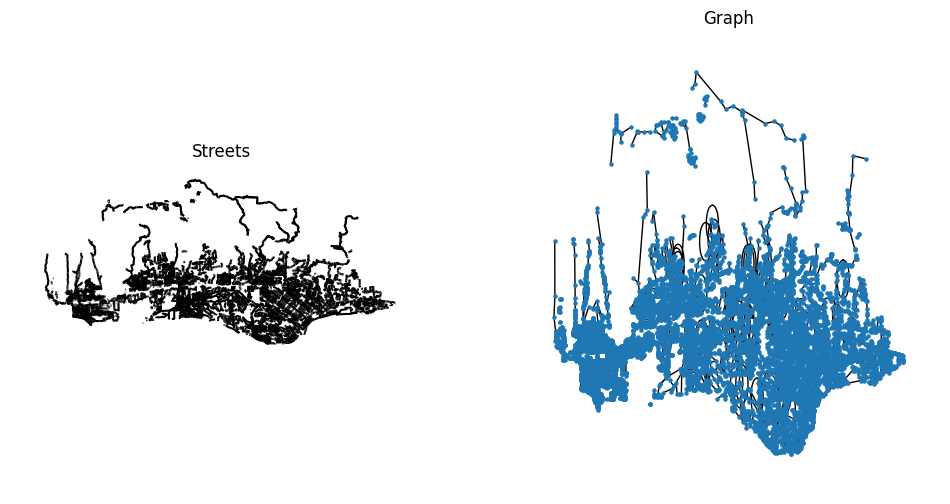

In [41]:
# positions = {n: [n[0], n[1]] for n in list(G.nodes)}

# # Plot
# f, ax = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)
# low_stress_polylines.plot(color="k", ax=ax[0])
# for i, facet in enumerate(ax):
#     facet.set_title(("Streets", "Graph")[i])
#     facet.axis("off")
# nx.draw(G, positions, ax=ax[1], node_size=5)

PROJCS["WGS 84 / UTM zone 10N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-123],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32610"]]
PROJCS["WGS_1984_UTM_Zone_10N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-123],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_